# Stance Detection Using Convolutional Neural Network Followed By Bidirectional Long Short-Term Memory

`Convolutional Neural Networks` `Bidirectional Long Short-Term Memory`  
`AraVec Word Vectors`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language` `Transfer Learning`

---

In this notebook, we rely on a hybrid architecture comprising a very simple convolutional neural network followed by a bidirectional long short-term memory to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The pretrained vectors (AraVec project) was introduced in the paper:
```
AraVec: A set of Arabic Word Embedding Models for use in Arabic NLP.
```

## Packages

In [ ]:
!pip install gensim
!pip install pyarabic

In [ ]:
import gensim
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from preprocessing import *
from utils import AraStanceData, evaluate, stance_to_int

## Raw data

- Download the raw data:



In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

- Let's start by reading the raw data:

In [ ]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_val = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_val.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [ ]:
instance_no = 60
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: محمد صلاح يظهر في  كأس العالم 2018 بحارس شخصي
Article text: أليسون: سعيد للعب مع «مو».. وأحب إظهار قدراتى فى الملعب وليس بالكلام كشف أليسون بيكر، حارس المنتخب البرازيلى، المنتقل حديثا لصفوف نادى ليفربول الإنجليزى، قادما من نادى روما الإيطالى فى صفقة تاريخية تعتبر الأكبر فى تاريخ كرة القدم على مستوى حراس المرمى، ووصلت إلى 72.5 مليون يورو- عن مضمون الرسالة التى وجهها له نجم المنتخب المصرى والريدز محمد صلاح. وقال بيكر فى حوار للموقع الرسمى لليفربول: صلاح أرسل رسالة لى أمس الأول، وقال لى: ماذا تنتظر؟ فقلت له: اهدأ أنا فى الطريق. وتابع البرازيلى: أنا سعيد جدا للعب معه مجددا، فهو لاعب ممتاز وشخص رائع وعظيم. وأضاف: «هذا هو الأهم بالنسبة لى، وهو أن أكون برفقة أناس رائعين، أحبهم كما أننى أحب إظهار قدراتى على أرضية الملعب وليس بالحديث وأتطلع للمشاركة وأنا حارس هادئ يسعى للفوز فقط. أعتقد أن أسلوب لعبى سيتماشى مع أسلوب كلوب. سأبذل كل ما لدىّ من أجل النادى والجماهير». وعن السبب فى موافقته على اللعب مع الريدز، قال الحارس البرازيلى: «ليفربول فريق معتاد على الفوز، ويمتلك جماهير رائعة تقف خ

- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Embedding layer

- We will use AraVec pretrained word vectors to represent the input.

### Preprocessing

- To increase the hit rate between the words in our raw data and the tokens (i.e. the keys in AraVec dictionary) in AraVec dictionary, we need to preprocess the data in a way similar to the preprocessing performed to produce those tokens.

- Let's use the following function to preprocess the training, validation, and testing data:

In [ ]:
# this function is resposible for the preprocessing routine
def preprocess(instances):
  instances = list(map(remove_puncuation, instances))
  instances = list(map(remove_diacritics, instances))
  instances = list(map(remove_longation, instances))
  instances = list(map(remove_unicode_codes, instances))
  instances = list(map(process_numerals, instances))
  instances = list(map(normalize, instances))
  instances = list(map(remove_extra_spaces, instances))
  return instances

- Before preprocessing each claim article pair, we need to concatenate them.

In [ ]:
# preprocess training data
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]
preprocessed_train_instances = preprocess(train_instances)

# preprocess validation data
val_instances = [raw_val.claims[raw_val.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_val.articles)]
preprocessed_val_instances = preprocess(val_instances)

# preprocess testing data
test_instances = [raw_test.claims[raw_test.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_test.articles)]
preprocessed_test_instances = preprocess(test_instances)

- Let's see a preprocessed instance:

In [ ]:
instance_no = 60
print(f"Claim Article text: {preprocessed_train_instances[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim Article text: محمد صلاح يظهر في كاس العالم الفان و ثماني عشره بحارس شخصي اليسون سعيد للعب مع مو واحب اظهار قدراتي في الملعب وليس بالكلام كشف اليسون بيكر حارس المنتخب البرازيلي المنتقل حديثا لصفوف نادي ليفربول الانجليزي قادما من نادي روما الايطالي في صفقه تاريخيه تعتبر الاكبر في تاريخ كره القدم علي مستوي حراس المرمي ووصلت الي اثنان و سبعون خمس مليون يورو عن مضمون الرساله التي وجهها له نجم المنتخب المصري والريدز محمد صلاح وقال بيكر في حوار للموقع الرسمي لليفربول صلاح ارسل رساله لي امس الاول وقال لي ماذا تنتظر ؟ فقلت له اهدا انا في الطريق وتابع البرازيلي انا سعيد جدا للعب معه مجددا فهو لاعب ممتاز وشخص رائع وعظيم واضاف هذا هو الاهم بالنسبه لي وهو ان اكون برفقه اناس رائعين احبهم كما انني احب اظهار قدراتي علي ارضيه الملعب وليس بالحديث واتطلع للمشاركه وانا حارس هادئ يسعي للفوز فقط اعتقد ان اسلوب لعبي سيتماشي مع اسلوب كلوب سابذل كل ما لدي من اجل النادي والجماهير وعن السبب في موافقته علي اللعب مع الريدز قال الحارس البرازيلي ليفربول فريق معتاد علي الفوز ويمتلك جماهير رائعه تقف خلفه اختبرت 

### Initialization

- Download the pretrained vectors first:

In [ ]:
!wget "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_300_wiki.zip"
!unzip "full_uni_cbow_300_wiki.zip"

- Load the pretrained vectors:

In [ ]:
embedding_model = gensim.models.Word2Vec.load("full_uni_cbow_300_wiki.mdl")
print("AraVect project contains",len(embedding_model.wv.index_to_key),"tokens")

AraVect project contains 320636 tokens


- We need to decide on the words we are going to use in the final representation of each instance, so we will use a vectorization layer to learn a vocabulary from our training data. We allowed 30K tokens in our vocabulary.
- We also going to need a word index, which maps words to indices like `{word1-->idx1, word2-->idx2, ...}`. The indices will be used to store the vector representation of each word in the embedding matrix.

In [ ]:
# Option 1 using TextVectorization layer
# max_tokens represents the maximum size of the vocabulary
vectorizer = tf.keras.layers.TextVectorization(max_tokens=30000, output_sequence_length=300, standardize=None)
text_ds = tf.data.Dataset.from_tensor_slices(preprocessed_train_instances).batch(128)

# learn the vocabulary based on the training data
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Option 2 using NLTK tokenizer
# import nltk
# from nltk import  word_tokenize
# nltk.download('punkt')

# def tokenization(text):
#   return word_tokenize(text)

# train_tokenized = list(map(tokenization, train_samples))
# tokens = [token for sublist in train_tokenized for token in sublist]
# tokens = set(tokens)
# word_index = dict(zip(tokens, range(len(tokens))))
# len(tokens)

- We are now ready to create an embedding matrix which maps token indices of our vocabulary to pretrained word vectors from AraVec project:

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  if embedding_model.wv.__contains__(word):
    embedding_matrix[i] = embedding_model.wv.get_vector(word)
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29578 words (422 misses)


- Let's see the representation of a random token:

In [ ]:
print(f"The word 'الثلاثاء' is at index {word_index['مرحبا']}")
print(f"The vector representation of 'الثلاثاء' is {embedding_matrix[word_index['الثلاثاء']]}")

The word 'الثلاثاء' is at index 16121
The vector representation of 'الثلاثاء' is [-3.09224582  0.55125713  0.58136082  0.55690795  0.62209177 -0.24616468
 -1.16805744  2.19624591  1.66737878 -1.71842837  0.80009604 -0.37939593
  2.26472807  1.35227621  0.27937481  1.37363136 -0.23499569  0.39701912
  1.49357843 -2.04478192  0.63254964 -0.36052722  0.66476351  1.13239837
 -0.19957216 -1.77682912  0.81066442 -0.24381542 -2.89442635 -0.28781021
 -1.91728437  0.08221091  0.15285496 -0.12959445  0.48114997 -1.24328351
  1.27518427  1.41444397 -2.2336452  -0.11999038  2.12921119 -1.84557533
  0.88319498  0.3521311  -0.68388164  1.42089999  1.83691549  1.02546704
  2.96264768 -1.84282851  0.23209584 -0.7614786   1.60187769 -0.70626545
 -1.13750899  1.24974394  0.17311509 -0.83907795 -2.61143136  0.16617733
 -2.49376202  1.14178491 -1.10266149  0.52799869  0.39724782  1.32616937
 -0.35095277  1.11568666  1.60204899  2.4259572   0.86045963 -0.79930484
 -0.20987584 -1.6634897  -2.4445765  -0.772

- Let's initialize our embedding layer with the embedding matrix:

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Datasets

In [ ]:
batch_size = 64

- Before creating the dataset, we need to vectorize the training, validation, and testing data using the adapted vectorizer. This means replace every word in an instance by its index in the word index:

In [ ]:
x_train = vectorizer(np.array([[s] for s in preprocessed_train_instances])).numpy()
x_val = vectorizer(np.array([[s] for s in preprocessed_val_instances])).numpy()
x_test = vectorizer(np.array([[s] for s in preprocessed_test_instances])).numpy()

- Let's see a vectorized instance:

In [ ]:
instance_no = 60
print(f"Original preprocessed instance: {preprocessed_train_instances[instance_no]}")
print(f"Vectorized instance: {x_train[instance_no]}")

Original preprocessed instance: محمد صلاح يظهر في كاس العالم الفان و ثماني عشره بحارس شخصي اليسون سعيد للعب مع مو واحب اظهار قدراتي في الملعب وليس بالكلام كشف اليسون بيكر حارس المنتخب البرازيلي المنتقل حديثا لصفوف نادي ليفربول الانجليزي قادما من نادي روما الايطالي في صفقه تاريخيه تعتبر الاكبر في تاريخ كره القدم علي مستوي حراس المرمي ووصلت الي اثنان و سبعون خمس مليون يورو عن مضمون الرساله التي وجهها له نجم المنتخب المصري والريدز محمد صلاح وقال بيكر في حوار للموقع الرسمي لليفربول صلاح ارسل رساله لي امس الاول وقال لي ماذا تنتظر ؟ فقلت له اهدا انا في الطريق وتابع البرازيلي انا سعيد جدا للعب معه مجددا فهو لاعب ممتاز وشخص رائع وعظيم واضاف هذا هو الاهم بالنسبه لي وهو ان اكون برفقه اناس رائعين احبهم كما انني احب اظهار قدراتي علي ارضيه الملعب وليس بالحديث واتطلع للمشاركه وانا حارس هادئ يسعي للفوز فقط اعتقد ان اسلوب لعبي سيتماشي مع اسلوب كلوب سابذل كل ما لدي من اجل النادي والجماهير وعن السبب في موافقته علي اللعب مع الريدز قال الحارس البرازيلي ليفربول فريق معتاد علي الفوز ويمتلك جماهير رائعه تقف 

- Let's initialize the datasets we are going to use for the training and testing:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_labels = [stance_to_int[s] for s in raw_val.stances]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## Model

- Now the datasets are ready, we can work on the model:

In [ ]:
lr = 1e-4
epochs = 100

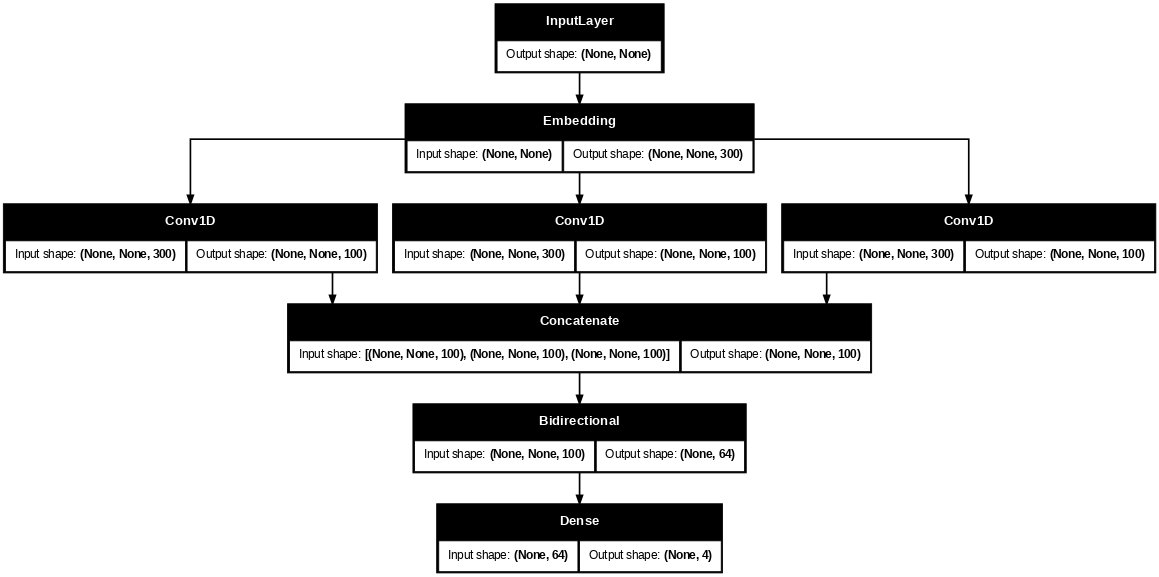

In [ ]:
int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
conv1 = tf.keras.layers.Conv1D(100, 2, activation="relu", use_bias=True)(embedded_sequences)
conv2 = tf.keras.layers.Conv1D(100, 3, activation="relu", use_bias=True)(embedded_sequences)
conv3 = tf.keras.layers.Conv1D(100, 4, activation="relu", use_bias=True)(embedded_sequences)

concatenated = tf.keras.layers.Concatenate(axis=1)([conv1, conv2, conv3])

lstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(concatenated)

logits = tf.keras.layers.Dense(4)(lstm_output)

model = tf.keras.models.Model(inputs=int_sequences_input, outputs=logits)

tf.keras.utils.plot_model(model, show_shapes=True, dpi=60)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 300)      │      9,000,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, None, 100)      │         60,100 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, None, 100)      │         90,100 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, None, 100)      │        120,100 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 100)      │              0 │ conv1d[0][0],          │
│                           │                        │                │ conv1d_1[0][0],        │
│                           │                        │                │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 64)             │         34,048 │ concatenate[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ bidirectional[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 9,305,208 (35.50 MB)

 Trainable params: 304,608 (1.16 MB)

 Non-trainable params: 9,000,600 (34.33 MB)

## Training

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]
history=model.fit(
  x=train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.4366 - loss: 1.2507 - val_accuracy: 0.5202 - val_loss: 1.2190
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5607 - loss: 1.0537 - val_accuracy: 0.5255 - val_loss: 1.1779
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.5993 - loss: 0.9592 - val_accuracy: 0.5395 - val_loss: 1.1321
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6445 - loss: 0.8803 - val_accuracy: 0.5554 - val_loss: 1.0904
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6769 - loss: 0.8082 - val_accuracy: 0.5694 - val_loss: 1.0553
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7063 - loss: 0.7420 - val_accuracy: 0.5835 - val_loss: 1.0267
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.7397 - loss: 0.6815 - val_accuracy: 0.6028 - val_loss: 1.0019
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7724 - loss: 0.6269 - val_accuracy: 0.

- Plot learning curves:

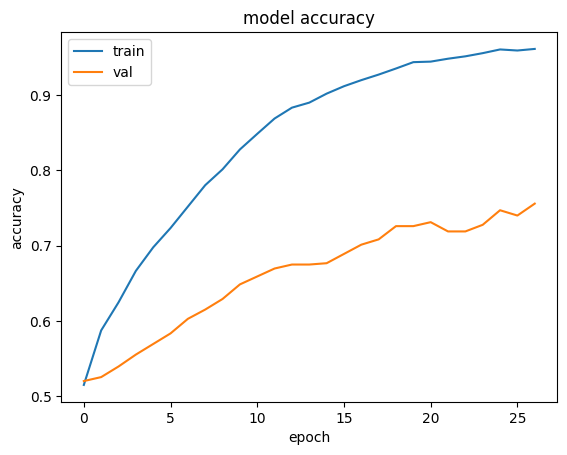

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

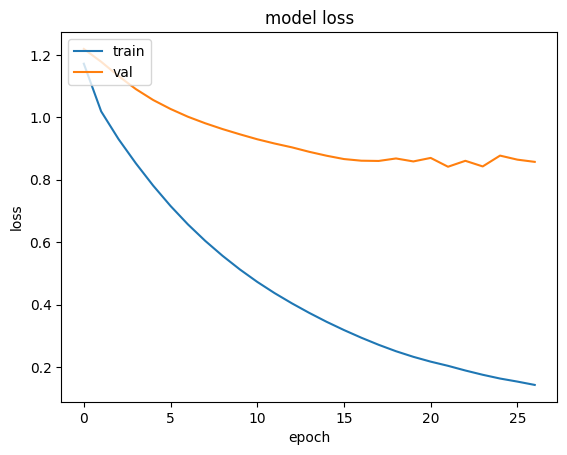

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, val_dataset, val_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7390 - loss: 0.9668
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Loss                       : 0.8572202920913696
Accuracy                   : 0.7557117750439367
F1 score                   : [0.74103586 0.65838509 0.46153846 0.83601286]
Macro F1 score             : 0.6742430682540508


In [ ]:
loss, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
print("Loss                       :", loss)
print("Accuracy                   :", accuracy)
print("F1 score                   :", f1score)
print("Macro F1 score             :", mf1score)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8279 - loss: 0.5944
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Loss                       : 0.7517261505126953
Accuracy                   : 0.7708978328173375
F1 score                   : [0.74336283 0.70866142 0.30434783 0.85286104]
Macro F1 score             : 0.6523082776726354


- Let's see the confusion matrix on the testing dataset:

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


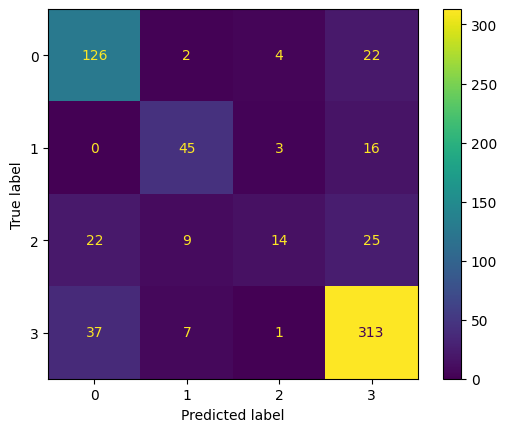

In [ ]:
y_pred = model.predict(test_dataset)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

- The model misclassifyies too many instances from the relatively easy 'unrelated' class.
- It also misclassifies a lot of instances from the 'agree', 'disagree', and 'discuss' classes.
- The confusion matrix suggests that the majority 'unrelated' class, besides the relatively more represented 'agree' class are dominating the dataset.

## A Word on overfitting

- Needs further investigation (next step).
- In [A first thought on overfitting](https://github.com/Ali-Mhrez/Stance-Detection/blob/main/SD_MLP.ipynb), we argue that the performance on the validation set stopped improving due to limits in the dataset, thus it is not clear how much we should attribute the learning curves to overfitting versus model struggling to capture the underlying concepts of the 'disagree' and 'discuss' classes.